### Submission 1: Price a European Up-and-out Call Option

In [1]:
"test"

'test'

In [31]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
### Initialize problem parameters
# option maturity
T = 1
# up-and-out barrier
L = 150
# current share price
S0 = 100
# strike price, at-the-money
K = 100
# risk-free rate
r = .08
# volatility
sigma = .3

# counterparty firm current value
v_0 = 200 # Our assumption 
# volatility for the counterparty's firm
sigma_firm = .25
# counterparty's debt, due in one year 
debt = 175
# correlation
corr = .2
# recovery rate
delta = 0.25

########
corr_matrix = np.array([[1, corr], [corr, 1]])
sample_sizes = range(1000, 50001, 1000)

In [ ]:
#### 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

In [157]:
def share_price(S, r, sigma, t_delta, Z):
    return S * np.exp((r - sigma**2/2)*t_delta + sigma*np.sqrt(t_delta)*Z) # dot product

def generate_share_price(S0, r, sigma, T, sample_size = 1000, timesteps = 12):
    price = [np.array([S0]*sample_size)]
    St = S0
    t, dt = np.linspace(0, T, timesteps+1, retstep=True)
    for _ in t[:-1]: # exclude the last time point as that is the maturity
        Z = stats.norm.rvs(size=sample_size)
        St = share_price(St, r, sigma, dt, Z)
        price.append(St)
    price = np.array(price)
    return pd.DataFrame(price, index=range(timesteps+1))

Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

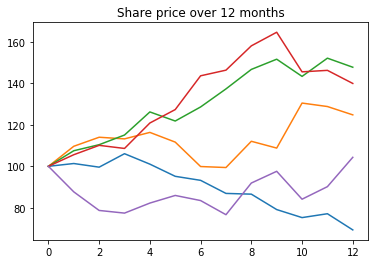

In [115]:
share_price_12_months = generate_share_price(S0, r, sigma, T, sample_size=5)
share_price_12_months.plot(title='Share price over 12 months', legend=False)

We can do the same thing to simulate counterparty firm's value

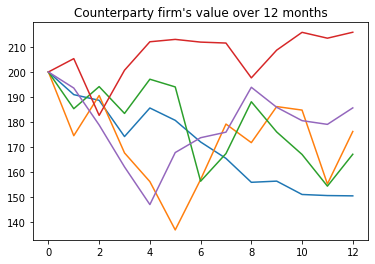

In [69]:
firm_value_12_months = generate_share_price(v_0, r, sigma_firm, T, sample_size=5)
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False)

In fact, we can also simulate the dynamic with finer resolution.

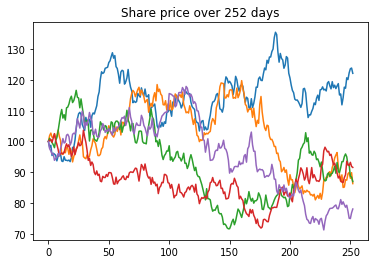

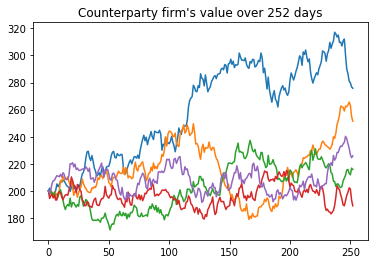

In [70]:
share_price_252_days = generate_share_price(S0, r, sigma, T, sample_size=5, timesteps=252)
share_price_252_days.plot(title='Share price over 252 days', legend=False)
firm_value_252_days = generate_share_price(v_0, r, sigma_firm, T, sample_size=5, timesteps=252)
firm_value_252_days.plot(title="Counterparty firm's value over 252 days", legend=False)

Let's visualize when the stopped process is appied

In [119]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        print(r)
        ret[r.idxmin():] = 0
    return ret

9     151.567747
11    152.067513
Name: 2, dtype: float64
8    157.994474
9    164.547299
Name: 3, dtype: float64


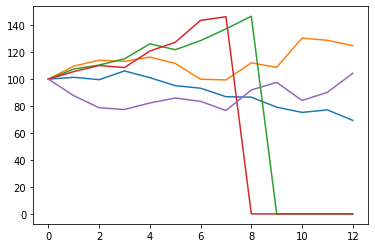

In [121]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0).plot(legend=False)

In [203]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([ 0.        , 24.77011766,  0.        ,  0.        ,  4.33391485])

Now let's increase the sample size to be able to estimate the mean price more accurately

In [158]:
share_price_paths = {}
firm_val_paths = {}

for sample_size in sample_sizes:
    share_val = generate_share_price(S0, r, sigma, T, sample_size=sample_size, timesteps=12)
    firm_val = generate_share_price(v_0, r, sigma_firm, T, sample_size=sample_size, timesteps=12)
    
    share_price_paths[sample_size] = share_val
    firm_val_paths[sample_size] = firm_val

In [162]:
%%capture
option_paths = share_price_paths[1000].apply(lambda s: stop(s, s>L), axis=0)

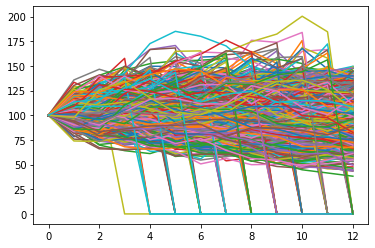

In [164]:
# plot monthly simulations for the lifetime of the option
option_paths.plot(legend=False)

#### 2. Determine the Monte Carlo estimates of the both the default-free value of the option and the Credit Valuation Adjustment

In [204]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-r*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


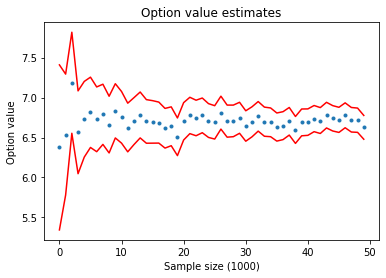

In [212]:
plt.plot(option_estimate, '.')
plt.plot(option_estimate + 3 * np.array(option_std), 'r')
plt.plot(option_estimate - 3 * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()